In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import sklearn as sk
import cv2 as cv
import torch.nn.functional as F
print("Loading Libraries...")

Loading Libraries...


Directory: archive/training/pituitary


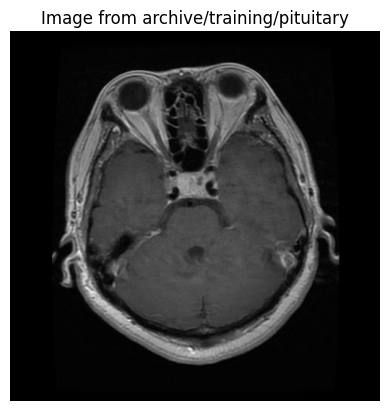

Directory: archive/training/notumor


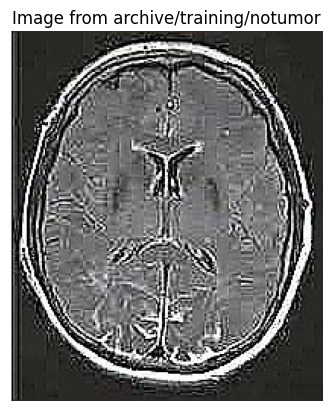

Directory: archive/training/glioma


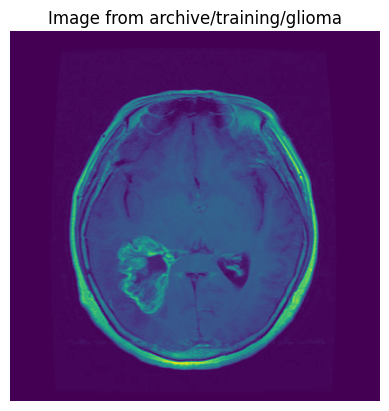

Directory: archive/training/meningioma


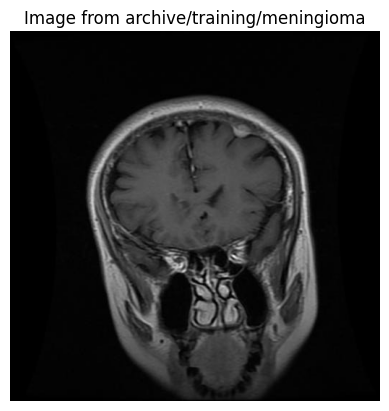

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
# Classes for the dataset
classes = [{
    'glioma': 0,
    'meningioma': 1,
    'notumor': 2,
    'pituitary': 3
}]

# Path to the root directory
root_dir = "archive/training"

# Walk through all directories and subdirectories
for subdir, _, files in os.walk(root_dir):
    if files:  # If there are files in the directory
        print(f"Directory: {subdir}")
        
        # Select the first image file in the directory
        first_image_file = next((file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))), None)
        
        if first_image_file:
            # Full path to the image
            image_path = os.path.join(subdir, first_image_file)
            
            # Open and display the image
            image = Image.open(image_path)
            plt.figure()
            plt.imshow(image)
            plt.axis('off')  # Hide axes for better viewing
            plt.title(f"Image from {subdir}")
            plt.show()
        else:
            print(f"No image files found in {subdir}")


# Ensures that the data was loaded properly


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(
            1, 6, 5
        )  # 1 input channel (grayscale), 6 output channels, 5x5 kernels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 24, 3)  # Adding third convolutional layer
        self.fc1 = nn.Linear(
            24 * 13 * 13, 120
        )  # Adjusted input size to match output from conv layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)  # Output for 4 classes

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # -> n, 6, 62, 62
        x = self.pool(F.leaky_relu(self.conv2(x)))  # -> n, 16, 29, 29
        x = F.leaky_relu(self.conv3(x))  # -> n, 24, 27, 27
        x = self.pool(x)  # -> n, 24, 14, 14
        x = x.view(-1, 24 * 13 * 13)  # Flatten
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
from PIL import Image
import numpy as np

def preprocess(img, x):
    """
    Preprocess an image:
    - Convert the image to grayscale.
    - Resize the image to x by x pixels.
    - Convert it to a NumPy array.

    Args:
    - img (PIL.Image.Image or str): The image to process or the path to the image.
    - x (int): The desired width and height of the image.

    Returns:
    - np.ndarray: A processed image as a grayscale NumPy array.
    """
    if isinstance(img, str):
        # If img is a path, open it
        img = Image.open(img)
    # Convert to grayscale
    img = img.convert("L")
    
    # Resize to x by x
    img = img.resize((x, x))
    
    # Convert to NumPy array
    img_array = np.array(img)
    
    return img_array
def display_image(img_array):
    """
    Display a NumPy array as an image.

    Args:
    - img_array (np.ndarray): The image array to display.
    """
    plt.imshow(img_array, cmap="gray")
    plt.axis("off")  # Hide axes for better viewing
    plt.title("Preprocessed Image")
    plt.show()

In [5]:
import random 
def get_random_image_path(root_dir):
    """
    Get a random image file path from a random subdirectory in the root directory.

    Args:
    - root_dir (str): The path to the root directory containing subdirectories.

    Returns:
    - str: The path to a randomly selected image file.
    """
    # List all subdirectories in the root directory
    subdirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    if not subdirs:
        raise ValueError(f"No subdirectories found in {root_dir}")
    
    # Pick a random subdirectory
    random_subdir = random.choice(subdirs)
    subdir_path = os.path.join(root_dir, random_subdir)
    
    # List all files in the chosen subdirectory
    files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
    
    if not files:
        raise ValueError(f"No files found in subdirectory {subdir_path}")
    
    # Pick a random file
    random_file = random.choice(files)
    random_file_path = os.path.join(subdir_path, random_file)
    
    return random_file_path

Random image path: archive/training/glioma/Tr-gl_0861.jpg
(128, 128)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


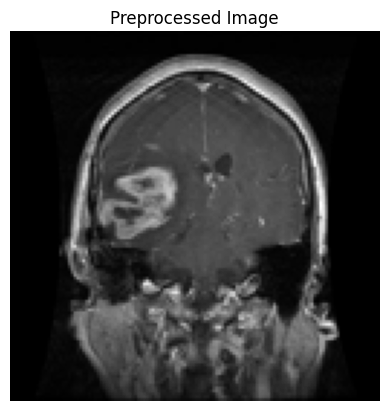

In [6]:
image_path = get_random_image_path("archive/training")# Arbitrary image path
print(f"Random image path: {image_path}")
processed_image = preprocess(image_path, 128)  # Resize image and turn to grayscale
print(processed_image.shape)  # Output: (64, 64)
print(processed_image)  # Grayscale pixel values
display_image(processed_image)

# Ensures all data was loaded properly

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper params
num_epochs = 15
batch_size = 64
learning_rate = 1e-3
num_classes = 4

model = ConvNet().to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
# Define the transform to convert the image to a tensor
transform = transforms.ToTensor()
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

img_tensor = transform(processed_image)
output = model(img_tensor)
_, predicted = torch.max(output.data, 1)
predicted = predicted.numpy()
print(predicted.item())
if predicted == 0:
    predicted = "glioma"
elif predicted == 1:
    predicted = "meningioma"
elif predicted == 2:
    predicted = "notumor"
elif predicted == 3:
    predicted = "pituitary"
print(predicted)

# Sample output, it's incorrect, but the training will change all that
# Right now the model is properly loaded, and it will need adjustments and training 

0
glioma
